In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
sqrt_t = ([[1,0],[0,np.exp((np.pi/8)*1j)]])
cool = UnitaryGate(sqrt_t)

{'1': 100}


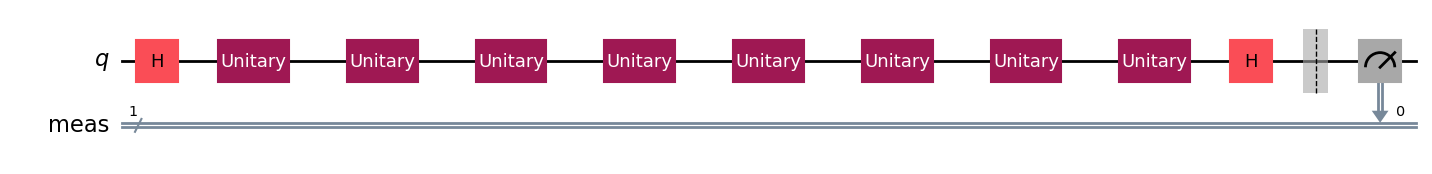

In [3]:
qc = QuantumCircuit(1)

qc.h(0)
for i in range(8):
    qc.append(cool, [0])
qc.h(0)

qc.measure_all()

sim = AerSimulator()
    
job = sim.run(qc, shots=100)

result = job.result()
counts = result.get_counts()

print(counts)
qc.draw("mpl")

In [4]:
qc = QuantumCircuit(1)

qc.rz(np.pi/8, 0)

print("Original circuit:")
print(qc.draw())
 
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
 
discretized = skd(qc)
 
print("Discretized circuit:")
print(discretized.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized).data))

#discretized.draw("mpl")

Original circuit:
   ┌─────────┐
q: ┤ Rz(π/8) ├
   └─────────┘
Discretized circuit:
   ┌───┐┌───┐┌─────┐┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─────┐┌───┐»
q: ┤ T ├┤ H ├┤ Tdg ├┤ H ├┤ Tdg ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ T ├┤ H ├┤ Tdg ├┤ H ├»
   └───┘└───┘└─────┘└───┘└─────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└─────┘└───┘»
«   ┌─────┐┌───┐
«q: ┤ Tdg ├┤ H ├
«   └─────┘└───┘
Error: 0.07944281142466891


/home/dustinseboldt/.local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/generate_basis_approximations.py:61: RuntimeWarning: The SolovayKitaev algorithm relies on scikit-learn's KDTree for a fast search over the basis approximations. Without this, we fallback onto a greedy search with is significantly slower. We highly suggest to install scikit-learn to use this feature.
  warnings.warn(


In [10]:
hmm = discretized.data
for instruction in hmm:
    print(instruction.name)

t
h
tdg
h
tdg
h
t
h
t
h
t
h
tdg
h
tdg
h


In [6]:
unit = np.array([[1,0],[0,1]])

t = np.array([[1,0],[0,np.exp((np.pi/4)*1j)]])

tdg = np.array([[1,0],[0,np.exp(-(np.pi/4)*1j)]])

s = np.array([[1,0],[0,np.exp((np.pi/2)*1j)]])

sdg = np.array([[1,0],[0,np.exp(-(np.pi/2)*1j)]])

h = np.array([[1,1],[1,-1]])
h = (1/np.sqrt(2))*h

test = np.array([[1,0],[0,np.exp((np.pi/8)*1j)]])

#print(test)

ok = np.matmul(unit,unit)

for instruction in hmm:
    if instruction.name == "t":
        ok = np.matmul(ok, t)
    if instruction.name == "tdg":
        ok = np.matmul(ok, tdg)
    if instruction.name == "h":
        ok = np.matmul(ok, h)

In [7]:
def dist(U,approx):
    ehm = np.conjugate(U.T)
    next = np.matmul(ehm, approx)
    hmm = np.abs(np.trace(next))
    return np.sqrt((2-hmm)/2)

def T(a,b):
    b = b*np.exp(1j*(np.pi/4))
    return a,b

def A(a,b):                             # = T adjoint
    b = b*np.exp(-1j*(np.pi/4))
    return a,b

def S(a,b):                             
    b = b*np.exp(1j*(np.pi/2))
    return a,b

def B(a,b):                             # = S adjoint
    b = b*np.exp(-1j*(np.pi/2))
    return a,b

def H(a,b):
    a = (1/(2**0.5))*(a+b)
    b = (1/(2**0.5))*(a-b)
    return a,b

def dustin(k: int, tgates: int):
    combs = ["A","T", "S", "B"]
    val_a , val_b = [],[]
    for i in range(tgates-1):
        all1 = [i+"A" for i in combs]
        all2 = [i+"T" for i in combs]
        all3 = [i+"S" for i in combs]
        all4 = [i+"B" for i in combs]
        combs = all1 + all2 + all3 + all4
    for i in range(len(combs)):
        seq = combs[i]
        a = 0
        b = 1
        for i in seq:
            if i == "A":
                a,b = H(a,b)
                a,b = A(a,b)
            if i == "T":
                a,b = H(a,b)
                a,b = T(a,b)
            if i == "S":
                a,b = H(a,b)
                a,b = S(a,b)
            if i == "B":
                a,b = H(a,b)
                a,b = B(a,b)
        val_a.append(a)
        val_b.append(b)
    angle = np.exp((1j*2*np.pi)/(2**(k+3)))
    winner = 0
    old = 3
    for i in range(len(val_a)):
        mine = mymatrix(combs[i])
        test = np.array([[1,0],[0,angle]])
        distance = dist(test, mine)
        if distance < old:
            winner = i
            old = distance
    return combs[winner]

def dustin_ez(k: int, tgates: int):
    combs = ["A","T"]
    val_a , val_b = [],[]
    for i in range(tgates-1):
        all1 = [i+"A" for i in combs]
        all2 = [i+"T" for i in combs]
        combs = all1 + all2
    for i in range(len(combs)):
        seq = combs[i]
        a = 0
        b = 1
        for i in seq:
            if i == "A":
                a,b = H(a,b)
                a,b = A(a,b)
            if i == "T":
                a,b = H(a,b)
                a,b = T(a,b)
        val_a.append(a)
        val_b.append(b)
    angle = np.exp((1j*2*np.pi)/(2**(k+3)))
    winner = 0
    old = 3
    for i in range(len(val_a)):
        mine = mymatrix(combs[i])
        test = np.array([[1,0],[0,angle]])
        distance = dist(test, mine)
        if distance < old:
            winner = i
            old = distance
    return combs[winner]

def mymatrix(seq):
    ok1 = np.matmul(unit,unit)
    for i in range(len(seq)):
        if seq[i] == "A":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,tdg)
        if seq[i] == "T":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,t)
        if seq[i] == "S":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,s)
        if seq[i] == "B":
            ok1 = np.matmul(ok1,h)
            ok1 = np.matmul(ok1,sdg)
    return ok1


AAATATAATATAAAA


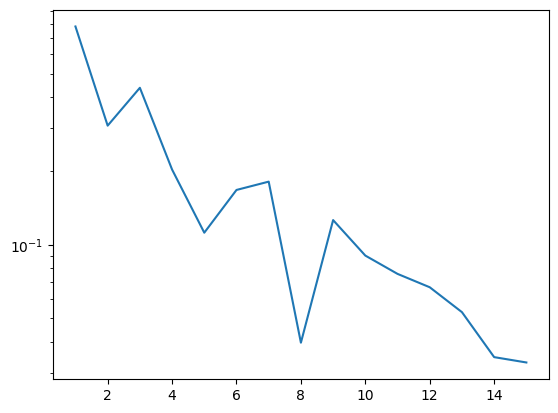

In [8]:
skibidi = dustin_ez(1,15)
print(skibidi)
ok1 = mymatrix(skibidi)

x = [i+1 for i in range(15)]

y = []
for i in x:
    skibidi = dustin_ez(1,i)
    ok = mymatrix(skibidi)
    bro = dist(test, ok)
    y.append(bro)

plt.plot(x,y)
plt.yscale("log")

In [9]:
print("Abstand zu Einheitsmatrix lol: ", dist(test, unit))
print("Abstand zu Solovay Kitaev Decomp: ", dist(test, ok))
print("Abstand zu meins: ", dist(test, ok1))

Abstand zu Einheitsmatrix lol:  0.13861716919909153
Abstand zu Solovay Kitaev Decomp:  0.032968689845652946
Abstand zu meins:  0.032968689845652946
